In [1]:
from iads import traitement_data as traitement

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [2]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

In [3]:
df_avis_up = pd.read_csv("../data/avis_clean.csv")

# II. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [4]:
categories = df_jeux_up.apply(traitement.extract_categories, axis=1)

In [5]:
categories[4]

array(['Card-driven', 'Combinaison', 'Coopération', 'Deck building',
       'Locomotion & voyage', 'Humour', 'Gestion', 'Science fiction'],
      dtype='<U19')

In [6]:
all_categories = []
for cat in categories:
    all_categories.extend(cat)

In [7]:
print("En moyenne", len(all_categories) / len(df_jeux_up), "categorie par jeu")

En moyenne 1.5693711847330054 categorie par jeu


In [8]:
uniq_cats, counts = np.unique(all_categories, return_counts=True)

- Nous pourrions faire un codage `one-hot` pour représenter les catégories, mais nous avons 184 catégories différentes, ce qui est énorme. Nous allons essayer de créer des clusters pour diminuer le nombre possible de catégories.

In [9]:
len(uniq_cats)

184

## 1. Word cloud des catégories :

In [10]:
from wordcloud import WordCloud

In [11]:
index_sort = counts.argsort()[::-1]
counts = counts[index_sort]
uniq_cats = uniq_cats[index_sort]

dico_categories = dict()

for i in range(len(uniq_cats)):
    cat = uniq_cats[i]
    dico_categories[cat] = counts[i]

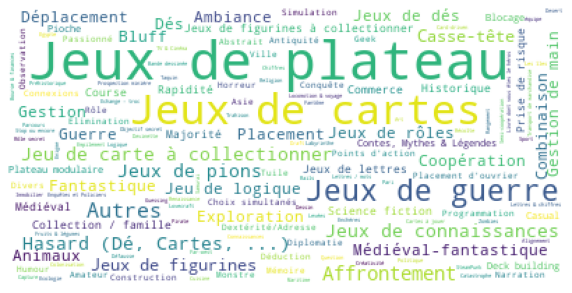

In [12]:
wordcloud = WordCloud(background_color='white', stopwords =[], max_words=len(uniq_cats)).generate_from_frequencies(dico_categories)    

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- On remarque que la distribution des catégories suit une loi de Zipf

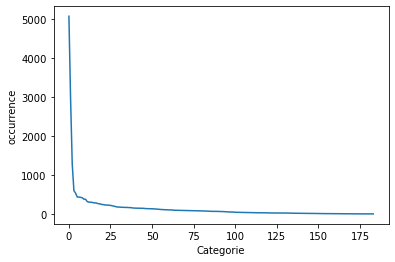

In [13]:
plt.plot(counts)
plt.xlabel("Categorie")
plt.ylabel("occurrence")
plt.show()

In [14]:
N = 10
for i in range(N):
    print(f"{i} - {uniq_cats[i]} : {counts[i]}")

0 - Jeux de plateau : 5081
1 - Jeux de cartes : 2956
2 - Jeux de guerre : 1279
3 - Autres : 599
4 - Affrontement : 535
5 - Jeu de carte à collectionner : 436
6 - Jeux de connaissances : 433
7 - Hasard (Dé, Cartes, ...) : 427
8 - Jeux de pions : 416
9 - Casse-tête : 380


## 2. Traitement des mots :

In [15]:
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster

2023-02-15 22:02:42.648410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 22:02:42.960724: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 22:02:43.009568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi801/linux64/lib
2023-02-15 22:02:43.009584: I tensorflow/compiler/xla/s

In [16]:
nlp = spacy.load('fr_core_news_md')

**On lemmatise les noms des catégories, ainsi obtenir des noms simple**

In [17]:
uniq_cats_lemma = []
for cat in uniq_cats:
    doc = nlp(str(cat))
    
    new_cat = ""
    for token in doc:
        new_cat += token.lemma_ + " "
        
    uniq_cats_lemma.append(new_cat.strip())

uniq_cats = uniq_cats_lemma

**On supprime les stops words**

In [18]:
sw = stopwords.words('french') + ["jeu", "être", "avoir", "plus", "tout", "très"] 

In [19]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words=sw)

In [20]:
X = vectorizer.fit_transform(uniq_cats)

- Les mots se trouvant dans les catégories : 

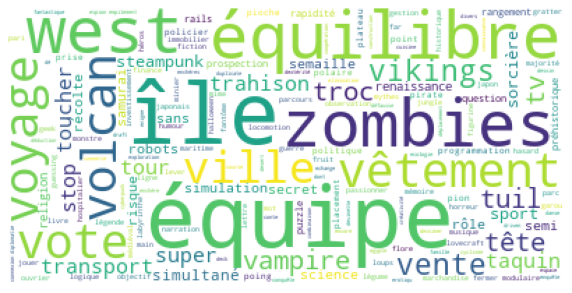

In [21]:
dico_cat = vectorizer.vocabulary_
wordcloud = WordCloud(background_color="white", max_words=len(dico_cat)).generate_from_frequencies(dico_cat)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Clustering**

In [22]:
import re
uniq_cats_sw = []

for cat in uniq_cats:
    words = cat.lower()
    words = re.split("[ -]+", words)
    new_cat = ""
    
    for w in words:
        if w in vectorizer.vocabulary_:
            new_cat += str(w) + " "
        
    new_cat = new_cat.strip()
    if new_cat == "":
        print(cat)
        continue
        
    uniq_cats_sw.append(new_cat)

uniq_cats = uniq_cats_sw

***1. Avec AffinityPropagation :***

In [23]:
clu = cluster.AffinityPropagation()

In [24]:
pred = clu.fit_predict(X)

In [25]:
print("Nombre de clusters trouvés :", max(pred))

Nombre de clusters trouvés : 28


- On réccupere les clusters générés

In [26]:
clusters = {}

for i in range(len(pred)):
    p = pred[i]
    
    if p not in clusters:
        clusters[p] = []
    
    clusters[p].append(uniq_cats[i])

**wordCloud de chaque cluster :**

In [27]:
nb_clus = len(clusters)

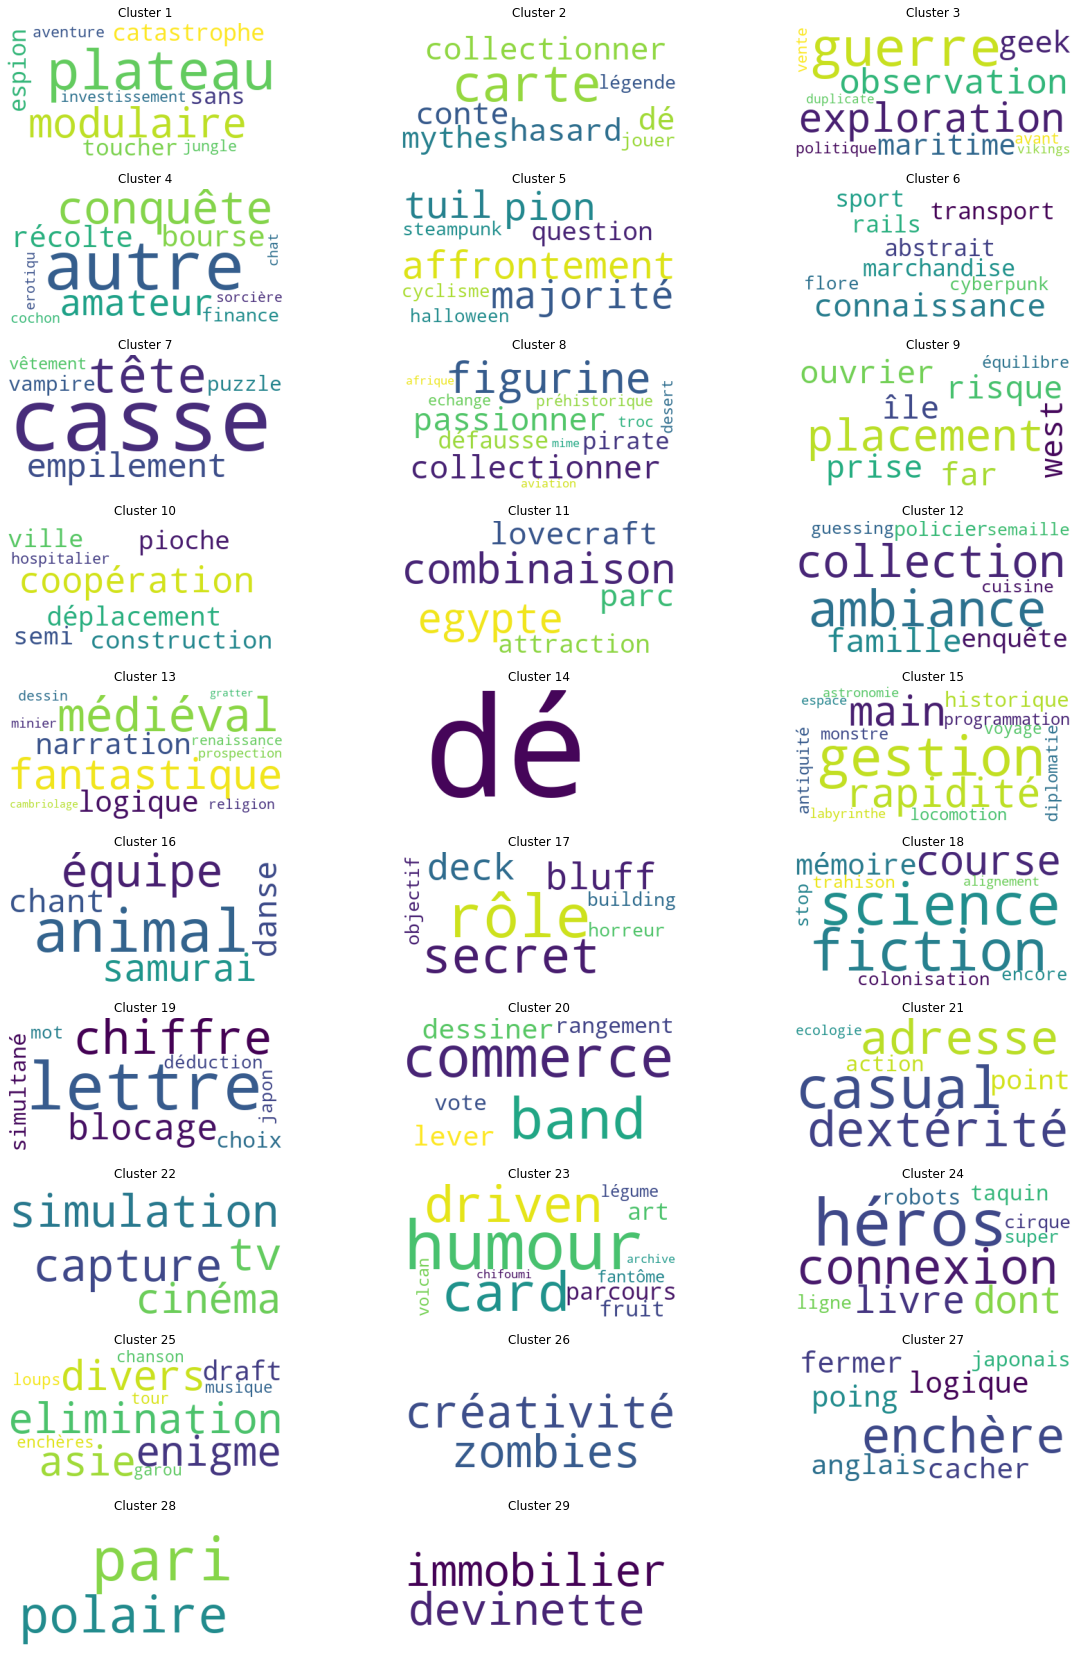

In [28]:
plt.figure(figsize=(20, 30))
i = 1
for c in clusters:
    corpus = " ".join(clusters[c])
    wordcloud = WordCloud(background_color='white', max_words=len(uniq_cats)).generate(corpus) 
    plt.subplot(nb_clus // 3 + 1, 3, i)
    plt.title(f"Cluster {i}")
    plt.imshow(wordcloud)
    plt.axis('off')
    i += 1